# BE/Bi 103, Fall 2014: Homework 4

## Due 1pm, Monday, October 26

*This homework was generated from a Jupyter notebook.  You can download the notebook [here](hw4.ipynb).*

In [1]:
import collections
import warnings

# The workhorses
import numpy as np
import pandas as pd
import scipy.stats as st

# Plotting modules
import matplotlib.pyplot as plt

# MCMC utilities
import emcee
import corner

# Numba for JITting log posteriors
import numba

# BE/Bi 103 utilities
import bebi103

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Seaborn makes plots look nice
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
sns.set_style('darkgrid', {'axes.facecolor': '(0.875, 0.875, 0.9)'})

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Problem 4.1 What's the difference? (30 pts)
**a)** In [Tutorial 3b](http://bebi103.caltech.edu/2015/tutorials/t3b_boolean_data.html#Comparison-of-two-reversal-probabilities), we compared two probabilities of reversal of worms after exposure to blue light for different strains.  Specifically, our aim was to compute $P(\delta \mid D, I)$, where $\delta \equiv p_\mathrm{AVA} - p_\mathrm{ASH}$.  That computation included some gnarly integrals.  It is much easier to do that calculaton with MCMC.  Do it!  As a reminder of the data set, 9 out of 35 ASH worms showed reversals, as did 33 out of 36 AVA worms.

**b)** In [problem 3.2d](hw3.html#Problem-3.2:-Dorsal-gradients-in-Drosophila-embryos-(50-pts) we looked at the differences between wild type and Dorsal-Venus fusion gradient widths graphically.  We will now revisit that by comparing the gradient widths for wild type measured via cross-sections and anti-Dorsal staining in the *dl1*/+ ; *dl-venus* / + genotype.  (Remember, the data can be downloaded [here](http://bebi103.caltech.edu/2015/protected/data/reeves_et_al.zip).)  Use MCMC to compute $P(\delta \mid D, I)$, where $\delta \equiv \sigma_{venus} - \sigma_{wt}$, the difference in the gradient widths between the two genotypes.  Be sure to explicitly state any modeling assumptions.

### Problem 4.1: solutions
**a)** In [Tutorial 3b](../tutorials/t3b_boolean_data.html#Comparison-of-two-reversal-probabilities), we wrote down that the joint probability distribution for ASH and AVA reversals is

\begin{align}
P(p_1, p_2\mid D, I) &= 
\frac{(n_1+1)!\,(n_2+1)!}{(n_1-n_{r1})!\,n_{r1}!\,(n_2 - n_{r2})!\,n_{r2}!} \\[0.5em]
&\;\;\;\;\;\;\;\;\times\,p_1^{n_{r1}}\,(1-p_1)^{n_1-n_{r1}}\,p_2^{n_{r2}}\,(1-p_2)^{n_2-n_{r2}},
\end{align}

where the subscript $1$ denotes ASH and the subscript $2$ denotes AVA.  We then did a change of variables to write the probability distribution in terms of $\delta = p_2 - p_1$ and $\gamma = p_2 + p_1$.  With MCMC, we do not need to do that!  We can just sample out of the distribution for $p_1$ and $p_2$, and then just subtract the samples.  So, now that we know our posterior, we can code up the log posterior and draw MCMC samples.

In [2]:
def log_post_binom(p, n, k):
    """
    Log posterior for a single binomial
    """
    if p < 0 or p > 1:
        return -np.inf

    return st.binom.logpmf(k, n, p)
    
    
def log_post(params, n1, n2, nr1, nr2):
    """
    Log posterior for two independent sets of Boolean data.
    """
    p1, p2 = params
    return log_post_binom(p1, n1, nr1) + log_post_binom(p2, n2, nr2)

Now, we just set up the sampler and run it.  I wrote a convenient function to perform an MCMC calculation using `emcee`.  The results are returned as a Pandas `DataFrame`, which makes access and keeping track of the results easier.  It is part of the [`bebi103_utils` package](https://github.com/justinbois/bebi103_utils).

In [3]:
# Arguments to pass to log posterior
args = (35, 36, 9, 33)

# Parameters and how we start them
params = collections.OrderedDict([('p1', (np.random.uniform, (0, 1))),
                                  ('p2', (np.random.uniform, (0, 1)))])

# Define walker settings
n_walkers = 50
n_burn = 500
n_steps = 5000

df_mcmc = bebi103.run_ensemble_emcee(log_post, n_burn, n_steps, 
                                     n_walkers=n_walkers, p_dict=params, 
                                     args=args, threads=6)

We will generate the same plots as we did in Tutorial 4, so we do a change of variables to change our samples from being of $p_1$ and $p_2$ to $\delta$ and $\gamma$.

In [4]:
# Compute delta and gamma from the samples
df_mcmc['delta'] = df_mcmc['p2'] - df_mcmc['p1']
df_mcmc['gamma'] = df_mcmc['p2'] + df_mcmc['p1']

We can now use the `corner` module to plot the posterior, including the marginalize posterior for $\delta$.

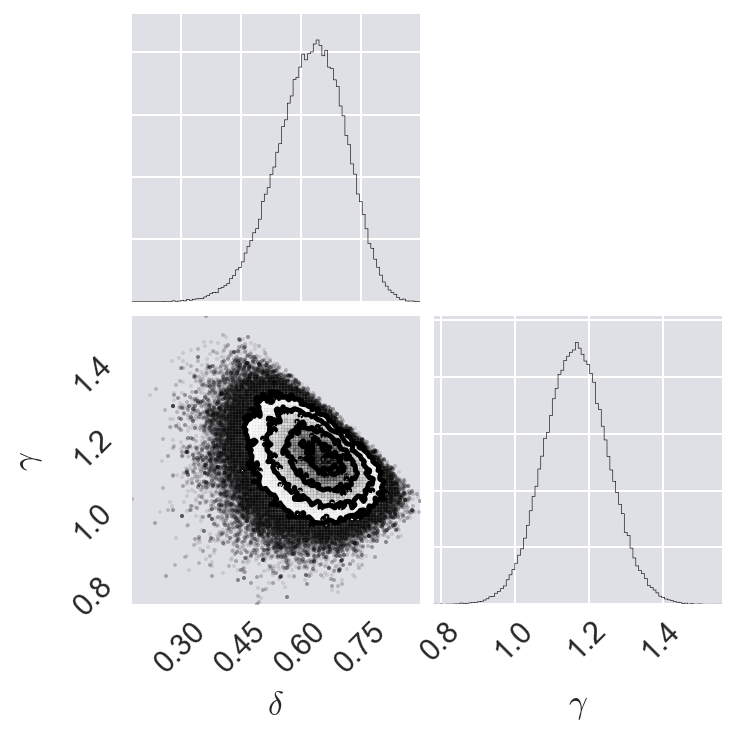

In [5]:
# Make corner plot
corner.corner(df_mcmc[['delta', 'gamma']], labels=[r'$\delta$', r'$\gamma$'], 
              bins=100);

As expected, this is just like the result we got in Tutorial 3b.  We can make a similar (and very pretty) plot using Seaborn.  We will use KDE to plot the marginalized posterior.  This is implemented in `seaborn.kdeplot`.

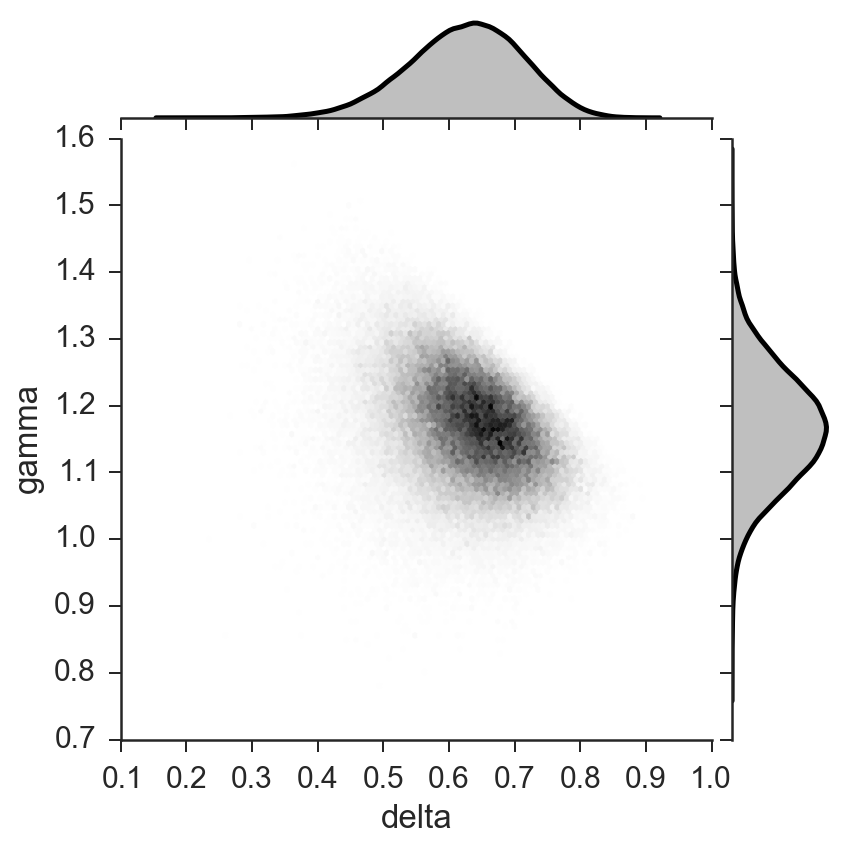

In [6]:
# Make plot of joint distribution
with sns.axes_style('ticks'):
    g = sns.JointGrid(x='delta', y='gamma', data=df_mcmc)
    g = g.plot_joint(plt.hexbin)
    g = g.plot_marginals(sns.kdeplot, shade=True, color='k')

**b)** We assume that for both techniques for measuring the Dorsal gradient, the measured gradient is Gaussian distributed.  Our aim, then, is to compare the difference in means of two Gaussian distributions.  We expect the means to be different, and we also expect $\sigma$ to be different, since we are measuring the gradient in different ways.  Specifically, we would like to know

\begin{align}
P(\delta, \sigma_1, \sigma_2 \mid D_1, D_2, I),
\end{align}

where $\delta = \mu_1 - \mu_2$, and we have used the subscript $1$ to denote wild type and $2$ to denote the Dorsal-Venus fusion.  This is essentially the [Behrens-Fisher problem](http://en.wikipedia.org/wiki/Behrens–Fisher_problem), and there are analytical expressions for it (e.g., in section 9.4.4 of Gregory's book).

But let's not bother with that.  Let's just use MCMC!  We will sample

\begin{align}
P(\mu_1, \mu_2, \sigma_1, \sigma_2 \mid D_1, D_2, I) &\propto P(D_1 \mid \mu_1, \sigma_1, I)\,P(D_2\mid\mu_2, \sigma_2, I)\\[1mm]
&\;\;\;\;\times P(\mu_1 \mid I)\,P(\mu_2 \mid I)\,P(\sigma_1 \mid I)\,P(\sigma_2 \mid I),
\end{align}

and from this we can compute $P(\delta, \sigma_1, \sigma_2 \mid D_1, D_2, I)$.  We will use a uniform prior for $\mu_1$ and $\mu_2$ and Jeffreys priors for $\sigma_1$ and $\sigma_2$ and Gaussian likelihoods.

First, we define the log posterior.

In [7]:
# Define log of the posterior
def log_post(p, x_1, x_2):
    """
    Returns the log of the posterior consisting of the product of Gaussians.
    p[0] = mu_1
    p[1] = mu_2
    p[2] = sigma_1
    p[3] = sigma_2
    """
    # Unpack parameters
    mu_1, mu_2, sigma_1, sigma_2 = p
    
    # Make sure we have everything in the right range
    if (sigma_1 < 0) or (sigma_2 < 0):
        return -np.inf

    # Compute separate parts of posterior from each sample
    log_post_1 = st.norm.logpdf(x_1, mu_1, sigma_1).sum() - np.log(sigma_1)
    log_post_2 = st.norm.logpdf(x_2, mu_2, sigma_2).sum() - np.log(sigma_1)

    # Add them up to return
    return log_post_1 + log_post_2

Of course, we'll need the data, so we load that in and we'll extract the columns we want and store them as NumPy arrays.

In [8]:
# Read in data
df = pd.read_csv('../data/reeves_et_al/reeves_gradient_width_various_methods.csv',
                 comment='#', header=[0,1])

# Extract columns and store as NumPy arrays
wt = df[('wt', 'cross-sections')].dropna().values
venus = df[('dl1/+; dl-venus/+', 'anti-Dorsal')].dropna().values

Now, we just set up and run the MCMC calculation.

In [9]:
# Arguments to pass to log posterior
args = (wt, venus)

# Parameters and how we start them
params = collections.OrderedDict([('mu_1', (np.random.uniform, (0, 1))),
                                  ('mu_2', (np.random.uniform, (0, 1))),
                                  ('sigma_1', (np.random.exponential, (0.1,))),
                                  ('sigma_2', (np.random.exponential, (0.1,)))])

# Define walker settings
n_walkers = 50
n_burn = 1000
n_steps = 10000

# Run MCMC
df_mcmc = bebi103.run_ensemble_emcee(log_post, n_burn, n_steps, 
                                     n_walkers=n_walkers, p_dict=params, 
                                     args=args, threads=6)

We can look at all of the results together with a corner plot.

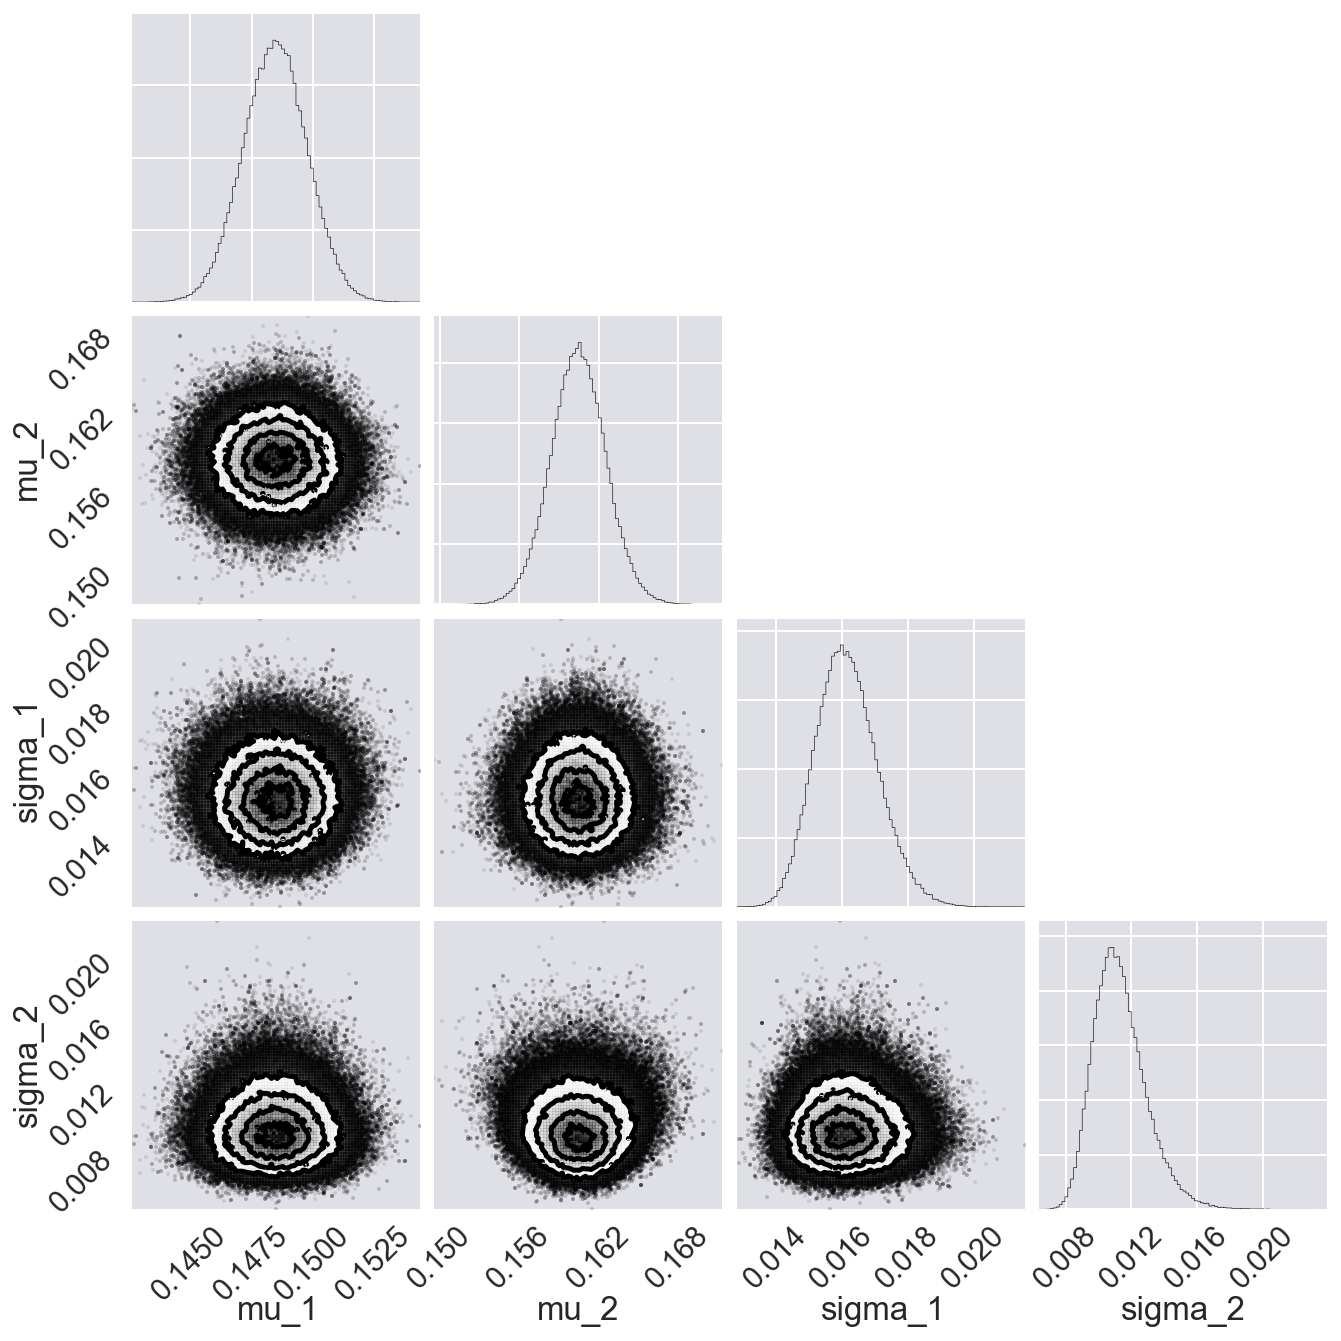

In [10]:
corner.corner(df_mcmc[df_mcmc.columns[:-1]], labels=df_mcmc.columns[:-1],
              bins=100);

We can also look at differences, which is what our main goal was anyhow.

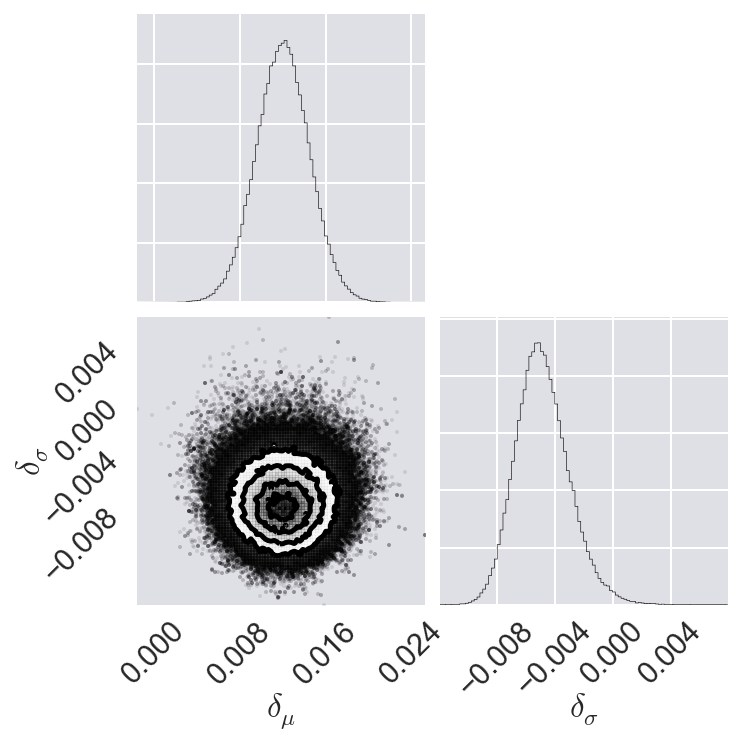

In [11]:
# Compute differences
df_mcmc['mu_diff'] = df_mcmc['mu_2'] - df_mcmc['mu_1']
df_mcmc['sigma_diff'] = df_mcmc['sigma_2'] - df_mcmc['sigma_1']

# Plot the results
corner.corner(df_mcmc[['mu_diff', 'sigma_diff']], 
              labels=[r'$\delta_\mu$', r'$\delta_\sigma$'], bins=100);

This tells use that the difference between the means is about 0.012, with the Venus fusion having a wider gradient.  Interestingly, there is less variation in the gradients in the Venus measurements.  We might also like these distributions as fractions of the wild type values.  This is easily done!

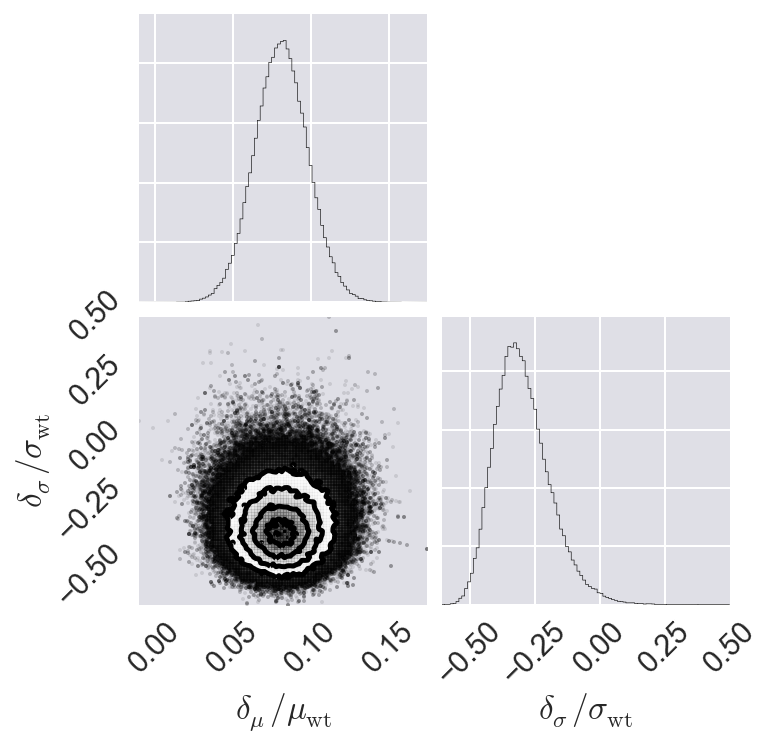

In [12]:
# Compute differences
df_mcmc['mu_diff_frac'] = df_mcmc['mu_diff'] / df_mcmc['mu_1']
df_mcmc['sigma_diff_frac'] = df_mcmc['sigma_diff'] / df_mcmc['sigma_1']

# Plot the results
corner.corner(df_mcmc[['mu_diff_frac', 'sigma_diff_frac']], 
              labels=[r'$\delta_\mu / \mu_\mathrm{wt}$', 
                      r'$\delta_\sigma / \sigma_\mathrm{wt}$'], bins=100);

So, the fractional difference in gradient width is about 7.5%, and the spread in gradient measurement is about 30% less in the Venus fusion.

<br />
<br />

### Problem 4.2: Ritonavir revisited with MCMC (20 pts)
In [problem 3.3b](hw3.html#Problem-3.3:-HIV-clearance-and-a-warning-about-regressions-(20-pts-extra-credit)), we plotted the posterior distribution for a regression of viral load in an HIV patient doing a contour plot.  Use MCMC to make a similar plot.  You do not need to make the contours; you can use the density of your MCMC samples to illustrate the posterior.  Remember, the data set may be downloaded [here](../data/hiv_data.csv).

### Problem 4.2: solution
We can borrow some of the code from [Homework 3](hw3_solutions.html) to define our posterior.  Unlike in that problem, we will not marginalized over the unknown variance in the measurements, $\sigma$, but keep it out of interest.  In this case, the posterior is

\begin{align}
P(V_0, c, \delta, \sigma \mid \{t_i, V_i\}, I) \propto \frac{1}{\sigma^{n+1}}
\prod_i \exp\left[-\frac{1}{2\sigma^2}\sum_i\left(V_i - V(t;V_0,c,\delta)\right)^2\right].
\end{align}

We will also explicitly bound our parameter values to be $0 \le c,\delta \le 10$ inside the log posterior function.

In [13]:
@numba.jit(nopython=True)
def viral_load_model(p, t):
    """Perelman model for viral load"""
    # Unpack parameters
    V_0, c, delta, _ = p
            
    # If c and d are close, use limiting expression
    if abs(c - delta) < 1e-9:
        return V_0 * (1 + delta * t +  (delta * t)**2 / 2) * np.exp(-delta * t)

    # Proceed with typical calculation
    bracket_term = c / (c - delta) * (np.exp(-delta * t) - np.exp(-c * t)) \
                                        - delta * t * np.exp(-c * t)

    return V_0 * (np.exp(-c * t) + c / (c - delta) * bracket_term)


@numba.jit(nopython=True)
def resid(p, t, V):
    """Residuals for viral load model with log parameters."""
    return V - viral_load_model(p, t)


def log_posterior(p, t, V, c_max, delta_max):
    """Log posterior for viral load model."""

    # Unpack parameters
    V_0, c, delta, sigma = p
    
    # Enforce bounds
    if (p < 0).any() or (c > c_max) or (delta > delta_max):
        return -np.inf

    return -(len(t) + 1) * np.log(sigma) \
                - np.sum(resid(p, t, V)**2) / 2 / sigma**2

Of course now we have to load in the data.

In [14]:
# Load data set using Pandas
df = pd.read_csv('../data/hiv_data.csv', comment='#')

We now just have to specify our initial walker positions and our other MCMC parameters and we can take our samples.  We will sample $c$, $\delta$, and $V_0$ out of uniform distributions and $\sigma$ out of an exponential. 

In [15]:
# Arguments to pass to log posterior (need NumPy arrays because using Numba)
args = (df['Days after administration'].values, 
        df['RNA copies per mL'].values, 10, 10)

# Parameters and how we start them
p_dict = collections.OrderedDict([('V_0', (np.random.uniform, (1e5, 2e5))),
                                  ('c', (np.random.uniform, (0, 10))),
                                  ('delta', (np.random.uniform, (0, 10))),
                                  ('sigma', (np.random.exponential, (1e3,)))])

# Define walker settings
n_walkers = 50
n_burn = 10000
n_steps = 500000

# Run MCMC
df_mcmc = bebi103.run_ensemble_emcee(log_posterior, n_burn, n_steps, 
                                     n_walkers=n_walkers, p_dict=p_dict, 
                                     args=args, threads=6)

Now that we have our samples, we can plot the results as a corner plot.

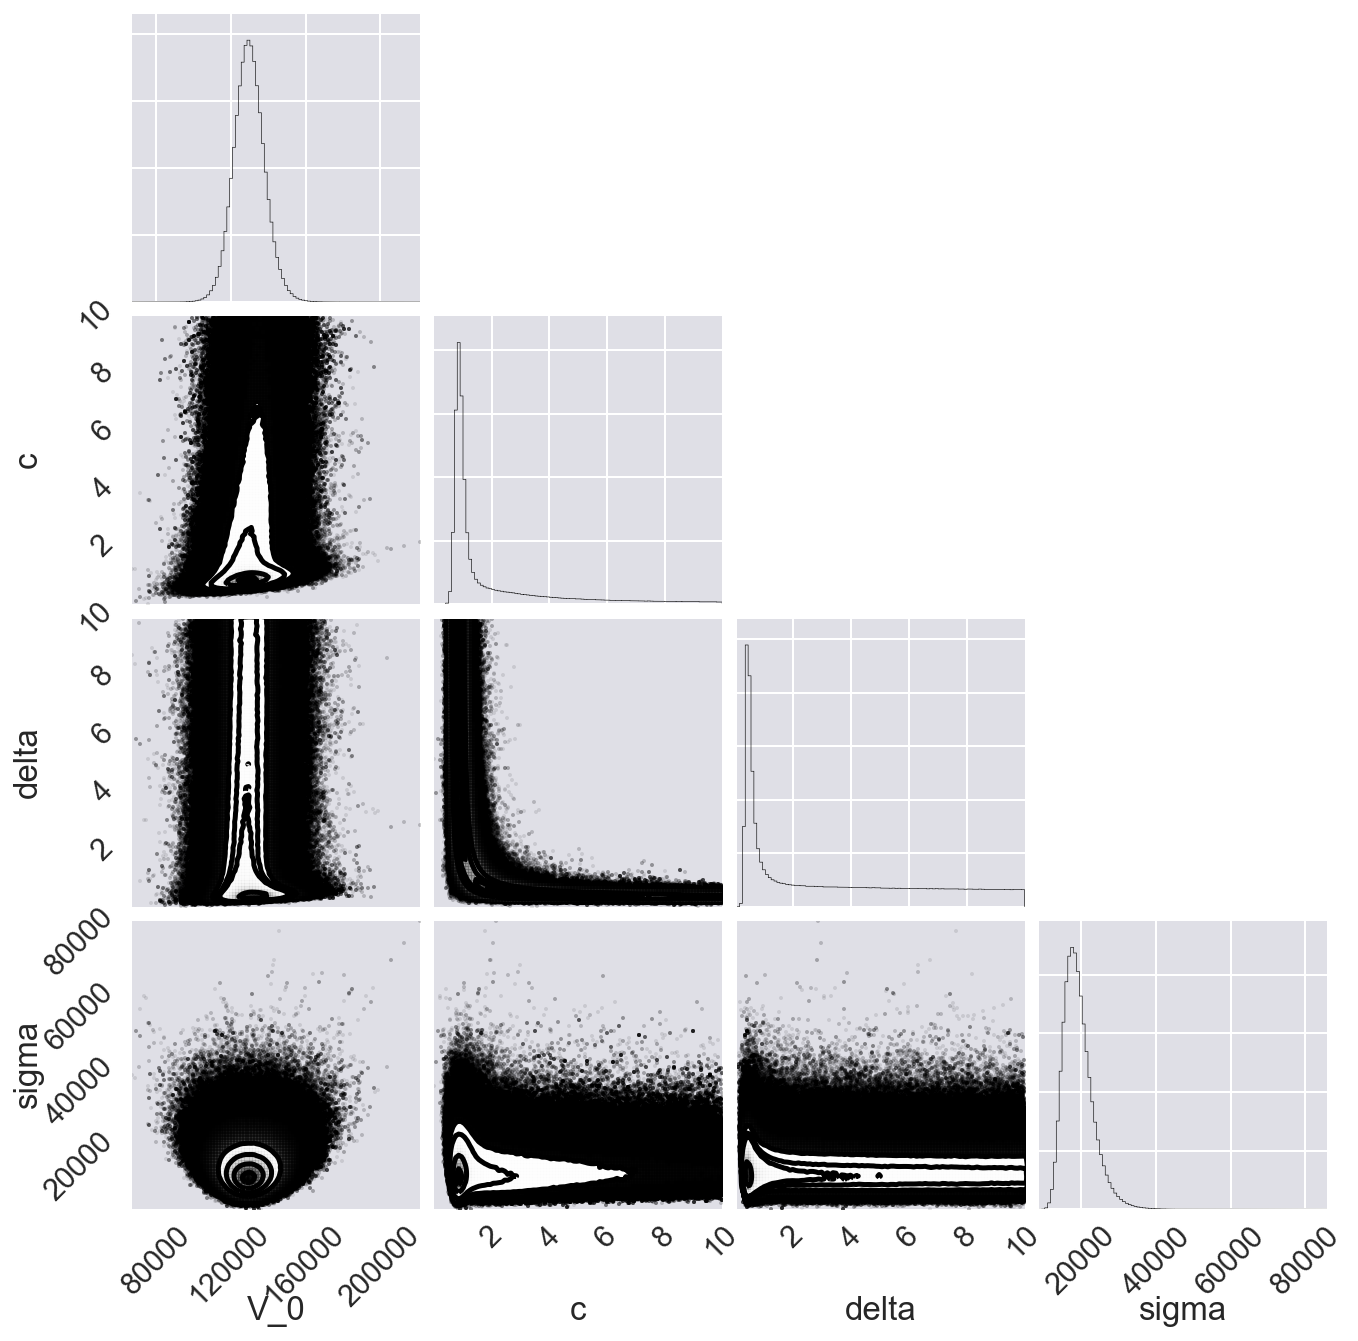

In [16]:
corner.corner(df_mcmc[df_mcmc.columns[:-1]], labels=df_mcmc.columns[:-1],
              bins=100);

The marginalized distributions for $c$ and $\delta$ have very long tails.  Note that the MAP we found in homework 3 approximately gives the peak of the marginal distribution for $\delta$, but *not* for $c$!  The MCMC MAP is about what we got in HW3.

In [17]:
# Find and display MCMC MAP
map_ind = np.argmax(df_mcmc['lnprob'])
df_mcmc.ix[map_ind]

V_0       129434.631935
c              2.661139
delta          0.525596
sigma      16208.698879
lnprob      -173.299661
Name: 5018707, dtype: float64

It is more stark when we plot the marginalized distribution of $c$ along with the MAP.

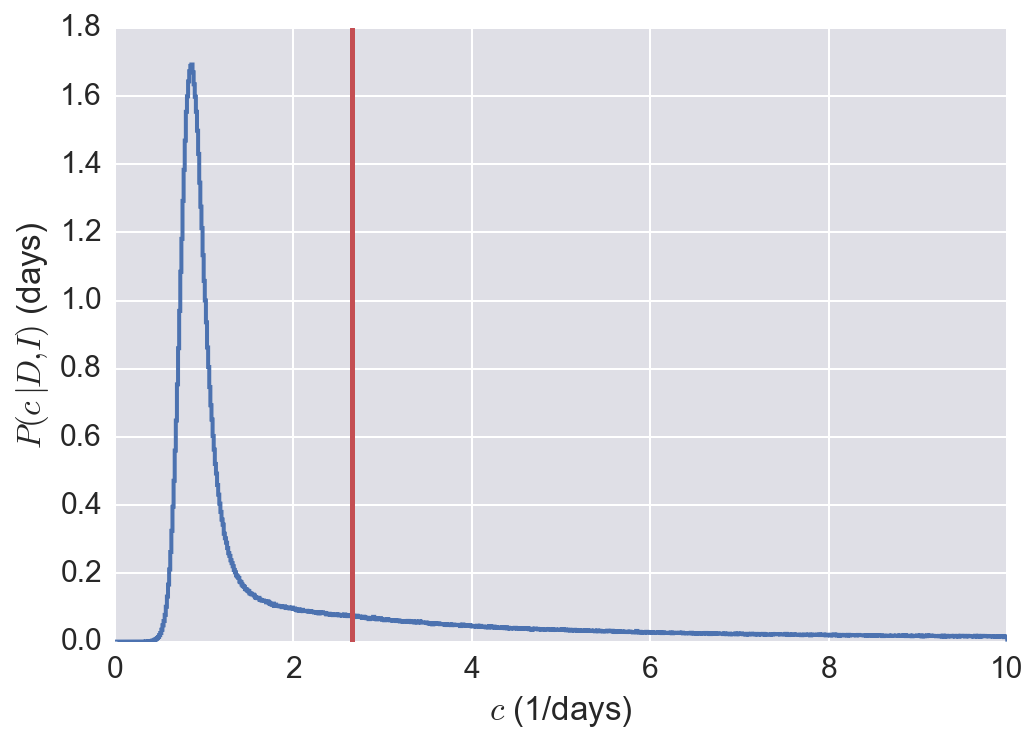

In [22]:
# Pull out MAP
c_map = df_mcmc['c'].ix[map_ind]

# Plot histogram and map as vertical red line
_ = plt.hist(df_mcmc['c'], bins=800, normed=True, histtype='step', lw=2)
plt.plot([c_map, c_map], plt.gca().get_ylim(), '-', color=sns.color_palette()[2])

# Clean up
plt.xlabel('$c$ (1/days)')
plt.ylabel(r'$P(c\mid D, I)$ (days)')

Without any other information, this suggests that using the MAP would overestimate the most probable HIV clearance rate due to the drug by about a factor of 5!  Then again, the reason we have the large peak at $c\approx 0.5$ days$^{-1}$ is that $\delta$ is allowed to take many values for that value of $c$, thereby allowing for a much better swatch of parameter space.

Now, we'll make a prettier plot using Seaborn and KDE on the marginalized posteriors.

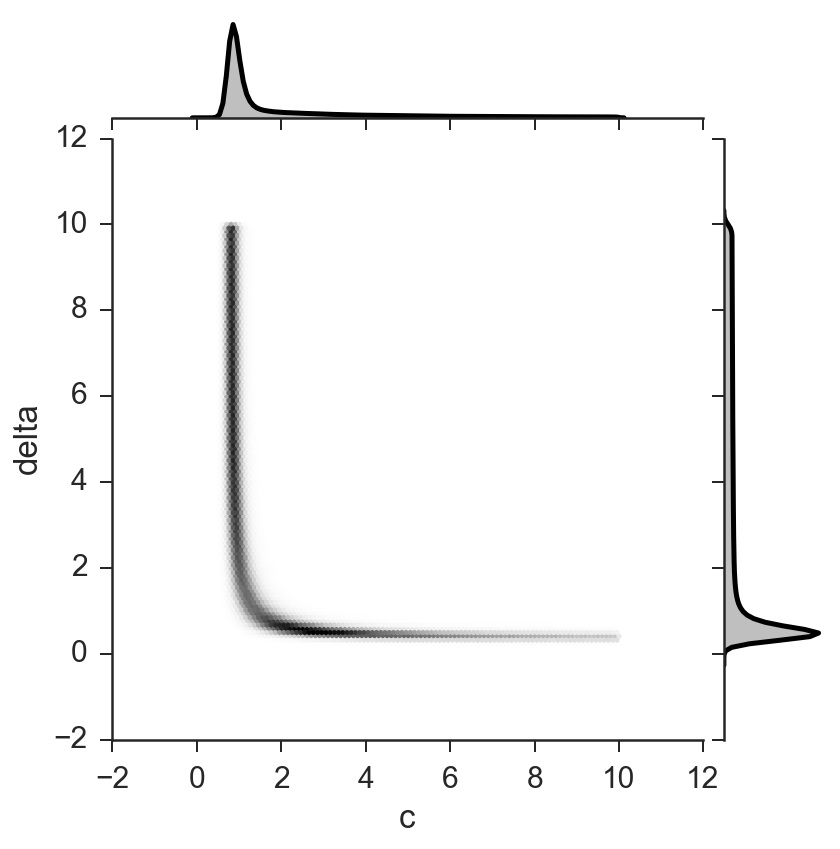

In [19]:
# Make plot of joint distribution
with sns.axes_style('ticks'):
    g = sns.JointGrid(x='c', y='delta', data=df_mcmc)
    g = g.plot_joint(plt.hexbin)
    g = g.plot_marginals(sns.kdeplot, shade=True, color='k')

Finally, we will make a clearer contour plot of the marginalized posterior using the utility function I wrote, `bebi103.norm_cumsum_2d()`.

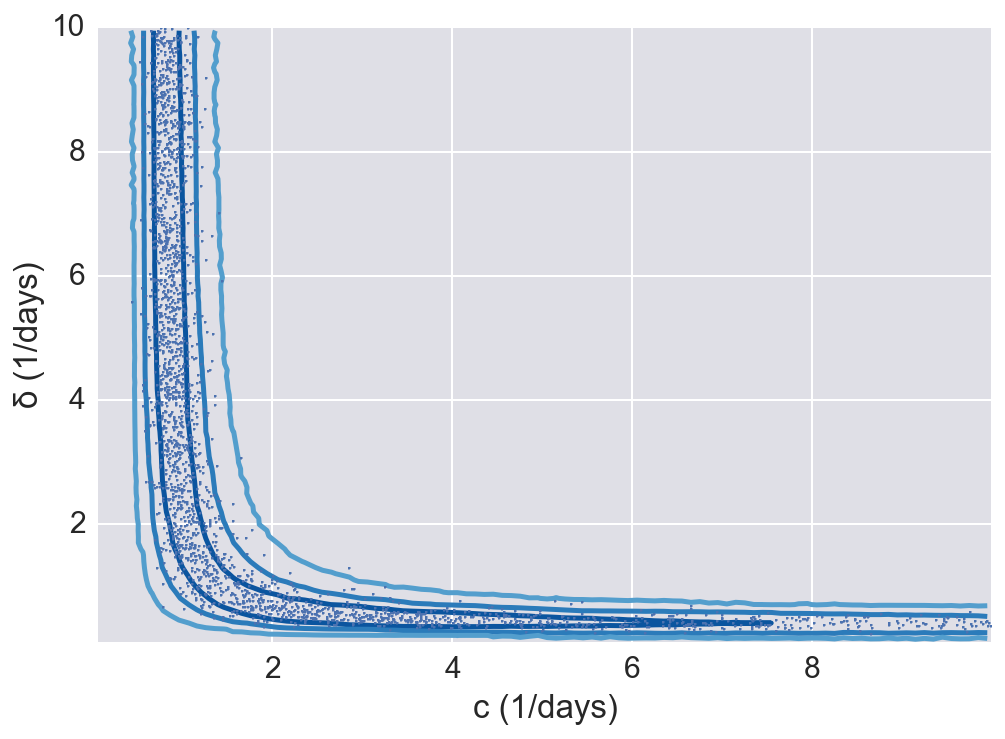

In [21]:
# Make normalized cumulative sum array
norm_cum_sum, c, delta = bebi103.norm_cumsum_2d(df_mcmc['c'], df_mcmc['delta'])

# Plot the contour plot
colors = sns.color_palette('Blues_r')[:3]
plt.contour(c, delta, norm_cum_sum, levels=(0.6827, 0.9545, 0.9973), 
            colors=colors)

# Plot 1/10000th of the samples
plt.plot(df_mcmc['c'].values[::10000], df_mcmc['delta'].values[::10000], '.',
         markersize=3)

# Axis labels
plt.xlabel('c (1/days)')
plt.ylabel('δ (1/days)')

<br />
<br />

### Problem 4.3: Spindle size revisited (25 pts)
In [Tutorial 3a](http://bebi103.caltech.edu/2015/tutorials/t3a_regression.html), we performed a regression on the data of Good, et al., describing how the length of mitotic spindles depends on the volume of cytoplasm it has available.  Perform that regression again using MCMC.  This time, though, do not marginalize $\sigma$, the inherent error in spindle length measurement, prior to sampling the posterior.  Sample $\sigma$ as well and comment on its distribution.  As a reminder, the data set may be downloaded [here](../data/invitro_droplet_data.csv).

### Problem 4.3: solution
First, we'll load in the data.

In [30]:
# Load data into DataFrame
df = pd.read_csv('../data/good_et_al/invitro_droplet_data.csv', comment='#')

# Pull our d and ell as NumPy arrays so we can use Numba
d = df['Droplet Diameter (um)'].values
ell = df['Spindle Length (um)'].values

We will borrow and modify some of the functions from Tutorial 3a to do this calculation.  We use a Gaussian likelihood and a Jeffreys prior for $\sigma$.  This is starting to be a bit routine, but it is still important to think carefully.  Importantly, we need to ensure that all parameters are positive, as that is their physical bound (which we encode in the prior).  We also know that $\gamma \le 1$ from [our discussions in Tutorial 3](http://bebi103.caltech.edu/2015/tutorials/t3a_regression.html#Model-b:-Spindle-size-is-dependent-on-total-tubulin-concentration).

In [41]:
@numba.jit(nopython=True)
def spindle_length(p, d):
    """
    Theoretical model for spindle length
    """
    theta, gamma, _ = p
    return gamma * d / (1 + (gamma * d / theta)**3)**(1/3)


def log_post(p, d, ell):
    """
    Compute log of posterior for single set of parameters.
    p[0] = theta
    p[1] = gamma
    p[2] = sigma
    """
        
    # Unpack parameters
    theta, gamma, sigma = p
    
    # Make sure everything is in range
    if (p < 0).any() or (gamma > 1):
        return -np.inf
    
    # Theoretical spindle length
    ell_theor = spindle_length(p, d)
    
    return -(len(d) + 1) * np.log(sigma) \
                    - np.sum((ell - ell_theor)**2) / 2 / sigma**2

Now, we just set up the MCMC calculation.  We draw starting points for walkers in the $\theta$ dimension from a uniform distribution from 0 to 50 µm and in the $\gamma$ dimension from a uniform distribution from 0 to 10.  We draw our starting $\sigma$ from an exponential distribution with mean 1 µm.

In [48]:
# Arguments to pass to log posterior (need NumPy arrays because using Numba)
args = (d, ell)

# Parameters and how we start them
p_dict = collections.OrderedDict([('theta', (np.random.uniform, (0, 50))),
                                  ('gamma', (np.random.uniform, (0, 1))),
                                  ('sigma', (np.random.exponential, (1,)))])

# Define walker settings
n_walkers = 50
n_burn = 5000
n_steps = 50000

# Run MCMC
df_mcmc = bebi103.run_ensemble_emcee(log_post, n_burn, n_steps, 
                                     n_walkers=n_walkers, p_dict=p_dict, 
                                     args=args, threads=6)

We can now make our favorite plots!

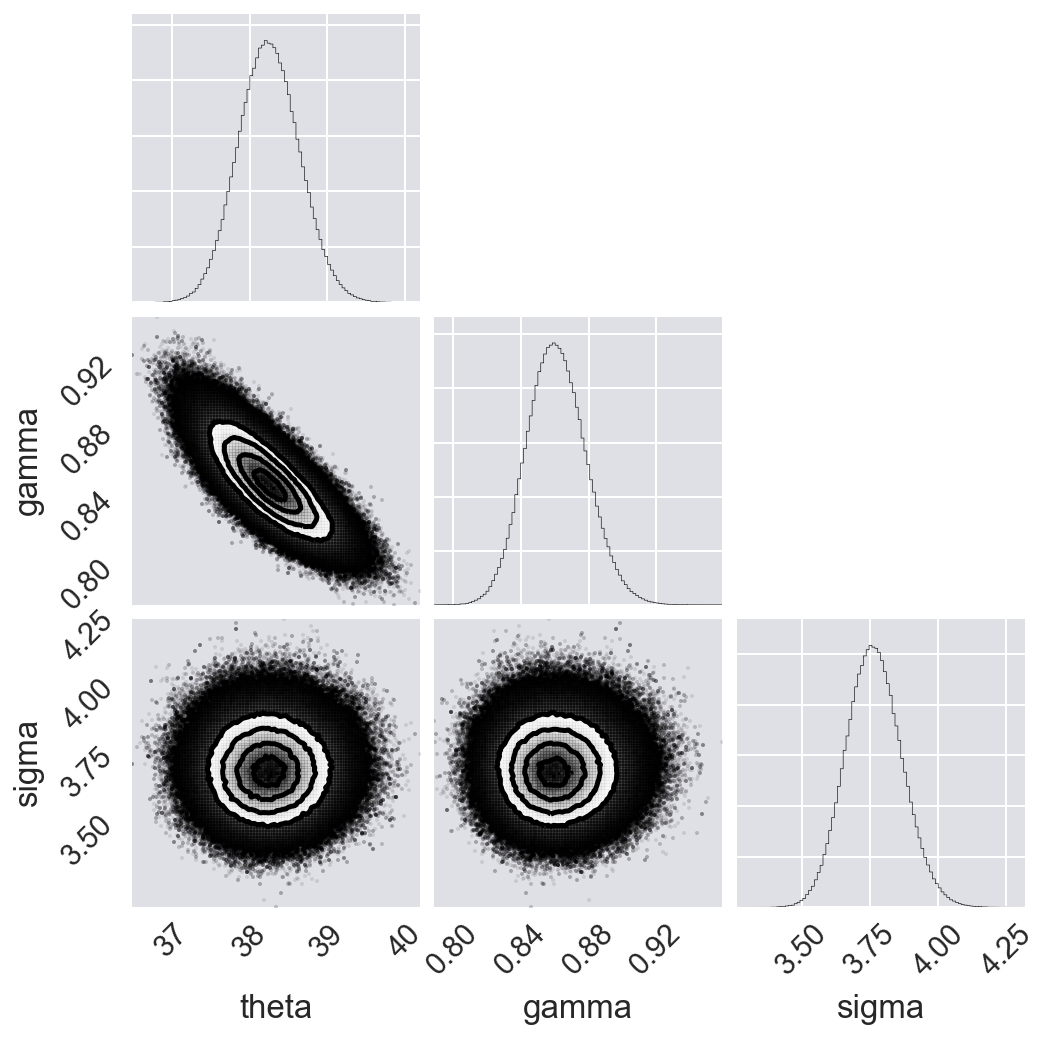

In [49]:
corner.corner(df_mcmc[df_mcmc.columns[:-1]], labels=df_mcmc.columns[:-1],
              bins=100);

Our estimates for $\gamma$ and $\theta$ are the same as we got in [Tutorial 3](http://bebi103.caltech.edu/2015/tutorials/t3a_regression.html#Computing-the-covariance-matrix) by optimization/Gaussian approximation.

In [52]:
print("""
MCMC estimates, assuming approximate Gaussianity:
theta: {0:.2f} ± {1:.2f} µm
gamma:  {2:.2f} ± {3:.2f}
sigma:  {4:.2f} ± {5:.2f} µm
""".format(df_mcmc['theta'].mean(), df_mcmc['theta'].std(),
           df_mcmc['gamma'].mean(), df_mcmc['gamma'].std(),
           df_mcmc['sigma'].mean(), df_mcmc['sigma'].std()))


MCMC estimates, assuming approximate Gaussianity:
theta: 38.24 ± 0.39 µm
gamma:  0.86 ± 0.02
sigma:  3.76 ± 0.10 µm



We also learned that the typical error in the spindle length measurements (under this model) is about 3.75 µm.

<br />

### Problem 4.4: Error propagation (25 pts)
Say you measure the same parameter $\mu$ twice, and you get error bars for each measurement.  Specifically, you obtain $\mu_1 \pm \sigma_1$ and $\mu_2 \pm \sigma_2$.  What is the most probable value of $\mu$ given these measurements, and what is its error bar?

### Problem 4.4: solution
We assume that each measurement is independent with a Gaussian likelihood, and a uniform prior for $\mu$.  Then, the posterior distribution for $\mu$ is
\begin{align}
P(\mu\mid \mu_1, \mu_2, \sigma_1, \sigma_2) \propto \exp\left[
-\frac{1}{2}\left(\frac{(\mu_1 - \mu)^2}{\sigma_1^2} + \frac{(\mu_2 - \mu)^2}{\sigma_2^2}\right)
\right].
\end{align}

To simplify this, we will take the logarithm.  As we simplify, we will keep throwing terms that are independent of $\mu$ into a constant term that we could deal with when we normalize the posterior at the end.

\begin{align}
\ln P(\mu\mid \mu_1, \mu_2, \sigma_1, \sigma_2) &= \text{const.} 
- \frac{1}{2}\left(\frac{(\mu_1 - \mu)^2}{\sigma_1^2} + \frac{(\mu_2 - \mu)^2}{\sigma_2^2}\right) \\[1em]
&= \text{const.} - \frac{1}{2}\left(\frac{\mu_1^2 + \mu^2 - 2\mu_1\mu}{\sigma_1^2} + \frac{\mu_2^2 + \mu^2 - 2\mu_2\mu}{\sigma_2^2}\right) \\[1em]
&= \text{const.} - 
\frac{\sigma_2^2\left(\mu_1^2 + \mu^2 - 2\mu_1\mu\right) 
+ \sigma_1^2\left(\mu_2^2 + \mu^2 - 2\mu_2\mu\right)}{2\sigma_1^2\sigma_2^2} \\[1em]
&= \text{const.} -
\frac{(\sigma_1^2 + \sigma_2^2)\mu^2 - 2(\sigma_1^2\mu_2 + \sigma_2^2\mu_1)\mu}{2\sigma_1^2\sigma_2^2} \\[1em]
&= \text{const.} - 
\frac{\mu^2 - 2\,\frac{\sigma_1^2\mu_2 + \sigma_2^2\mu_1}{\sigma_1^2 + \sigma_2^2}\,\mu}{\left.2\sigma_1^2\sigma_2^2 \middle/ (\sigma_1^2 + \sigma_2^2)\right.}
 \\[1em]
&= \text{const.} - \frac{\left(\mu - \frac{\sigma_1^2\mu_2 + \sigma_2^2\mu_1}{\sigma_1^2 + \sigma_2^2}\right)^2}{\left.2\sigma_1^2\sigma_2^2 \middle/ (\sigma_1^2 + \sigma_2^2)\right.}
\end{align}

From this log posterior, we see that $\mu$ is Gaussian distributed with variance

\begin{align}
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2 + \sigma_2^2}
= \left(\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}\right)^{-1}
\end{align}

and mean

\begin{align}
\frac{\sigma_1^2\mu_2 + \sigma_2^2\mu_1}{\sigma_1^2 + \sigma_2^2} = 
\sigma^2\left(\frac{\mu_1}{\sigma_1^2} + \frac{\mu_2}{\sigma_2^2}\right).
\end{align}

So, we know the posterior is Gaussian (exactly, not approximately), and we would report

\begin{align}
\mu = \left(\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}\right)^{-1}\left(\frac{\mu_1}{\sigma_1^2} + \frac{\mu_2}{\sigma_2^2}\right)
\pm \left(\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}\right)^{-1/2}.
\end{align}

This result is in fact general.  For $n$ measurements $\{\mu_i, \sigma_i\}$, the resulting posterior for the parameter $\mu$ is Gaussian distributed with variance

\begin{align}
\sigma^2 = \left(\sum_i \frac{1}{\sigma_i^2}\right)^{-1}
\end{align}

and mean

\begin{align}
\sigma^2\left(\sum_i \frac{\mu_i}{\sigma_i^2}\right).
\end{align}

In other words, the variance is given by $n$ times the harmonic mean of the variance of the individual measurements.  The most probable $\mu$ is the inverse variance-weighted mean of the measurements.

<br />

### Problem 4.5: Nonlinear regression in Spire-actin binding (50 pts extra credit)

In this problem, we will explore many aspects of doing nonlinear regression.  You will learn about numerical optimization techniques to use when least squares is not appropriate and about using informative priors.  You will also learn, again, how important it is to do the work up front as you develop your model to best describe your data.

#### Background on the data set and analysis of binding

The data set we will consider in this problem comes from a [recent paper by Rasson and coworkers](http://bebi103.caltech.edu/2015/protected/papers/rasson_2014.pdf) in Margot Quinlan's lab at UCLA.  You can download the data set [here](http://bebi103.caltech.edu/2015/protected/data/rasson_et_al.zip).

The authors were investigating the biochemistry of Spire-actin interactions.  Spire is an actin binding protein that can nucleate actin filaments.  In particular, it has four domains (called $S_A$, $S_B$, $S_C$, and $S_D$), which bind monomeric actin.  These four domains, acting in concert, can line up actin monomers to help in nucleation.  In this problem, we will determine the dissociation constant, $K_d$, describing binding of $S_D$ to monomeric actin.

The strategy to determine $K_d$ is to perform a titration experiment and then use nonlinear regression to determine $K_d$.  Consider the chemical reaction describing $S_D$-actin binding.

\begin{align}
\text{actin}\cdot S_D \rightleftharpoons \text{actin} + S_D,
\end{align}

which has dissociation constant $K_d$.  Let $c_a$ be the equilibrium concentration of actin and $c_d$ be the equilibrium concentration of $S_D$, and $c_{ad}$ be the equilibrium concentration of bound actin-$S_D$. Then, at equilibrium,

\begin{align}
K_d = \frac{c_a c_d}{c_{ad}}.
\end{align}


Now, if we start with a total actin concentration of $c_a^0$ and a total $S_D$ concentration of $c_d^0$, we also have

\begin{align}
c_a^0 = c_a + c_{ad}, \\[1mm]
c_d^0 = c_d + c_{ad},
\end{align}

by conservation of mass.

With these relations, we can now write $c_{ad}$ in terms of $c_a^0$ and $c_d^0$, which are known quantities (this is what we pipetted into our solution).

\begin{align}
K_d &= \frac{(c_a^0 - c_{ad})(c_d^0 - c_{ad})}{c_{ad}},\\[1mm]
\Rightarrow\;&\;\;c_{ad}^2 - (K_d + c_a^0 + c_d^0)c_{ad} + c_a^0 c_d^0 = 0.
\end{align}

The solution to this quadratic equation gives $c_{ad}$ as a function of $K_d$.  Note that we must choose one of the two roots, the one that is physical.  The physical root satisfies $0 < c_{ad} < \min(c_a^0, c_d^0)$.  In this case, it is

\begin{align}
c_{ad} = \frac{1}{2}\left(K_d + c_a^0 + c_d^0 - \sqrt{\left(K_d + c_a^0 + c_d^0\right)^2 - 4c_a^0c_d^0}\right).
\end{align}

We can write a function to compute $c_{ad}$ for a given $K_d$, $c_a^0$, and $c_d^0$.  Though we know the solution using the quadratic formula, we will use `np.roots` to do the calculation.

In [ ]:
# Function to compute c_ad for dissociation reactions
def c_ad_dissoc(K_d, c_a_0, c_d_0):
    """
    Compute concentration of actin-S_D for a given value of c_a_0 and c_d_0.
    """
    poly_coeffs = np.array([1.0, 
                            -(K_d + c_a_0 + c_d_0), 
                            c_a_0 * c_d_0])
    
    # Use np.roots to solve for c_ad
    return np.roots(poly_coeffs).min()

So, since we know $c_a^0$ and $c_d^0$, if we can measure $c_{ad}$, we can compute $K_d$.  In a titration experiment, we fix $c_d^0$ and vary $c_a^0$, and measure $c_{ad}$ to get a curve.  From the curve, we can perform a regression to get $K_d$.  Example curves are shown below.

In [ ]:
# Values of K_d to consider, units of micromolar (uM)
K_d = [0.1, 0.3, 1.0, 3.0, 10.0]

# Fixed S_D concentration, units of micromolar (uM)
c_d_0 = 0.005

# Varied actin concentration for plotting (uM)
c_a_0 = np.linspace(0.0, 10.0, 200)

# Make curves and plot
colors = sns.color_palette('Blues', 7)
for i in range(len(K_d)):
    # Compute c_ad over the values of c_a_0.
    c_ad = np.empty_like(c_a_0)
    for j in range(len(c_a_0)):
        c_ad[j] = c_ad_dissoc(K_d[i], c_a_0[j], c_d_0)

    # Make plot
    label = u'$K_d = %g$ µm' % K_d[i]
    plt.plot(c_a_0, c_ad, '-', color=colors[i+2], label=label)
    plt.xlabel(u'$c_a^0$ (µm)')
    plt.ylabel(u'$c_{ad}^0$ (µm)')
    plt.legend(loc='lower right')

The problem with this approach is that we do not have a direct way of measuring $c_{ad}$.  The authors instead employed [fluorescence anisotropy](http://en.wikipedia.org/wiki/Fluorescence_anisotropy).  I will not go into the details here of how it works, but will simply say that larger complexes rotate more slowly, and therefore give a higher fluorescence anisotropy signal (which is dimensionless) than do smaller complexes.

So, the authors fluorescently tagged $S_D$.  We will call this molecule $S_{D^*}$, with concentration $c_{d^*}$.  When free in solution, this molecule gives an anisotropy signal of $r_f$.  When bound to actin, it gives an anisotropy signal of $r_b$.  So, the total anisotropy signal we could detect is

\begin{align}
r = \frac{1}{c_{d^*}^0}\,\left(r_f c_{d^*} + r_b c_{ad^*}\right).
\end{align}

Clearly, when all $S_{D^*}$ is free, the anisotropy signal is $r_f$ and when all $S_{D^*}$ is bound to actin, the signal is $r_b$.  Remembering our conservation of mass, $c_{d^*} = c_{d^*}^0 - c_{ad^*}$, we have

\begin{align}
r = \frac{1}{c_{d^*}^0}\,\left(r_f (c_{d^*}^0 - c_{ad^*}) + r_b c_{ad^*}\right)
= r_f  + \frac{r_b-r_f}{c_{d^*}^0}\, c_{ad^*}.
\end{align}

Now, returning to our equilibrium expression, we have

\begin{align}
c_{ad^*} = \frac{1}{2}\left(K_d^* + c_a^0 + c_{d^*}^0 - \sqrt{\left(K_d^* + c_a^0 + c_{d^*}^0\right)^2 - 4c_a^0c_{d^*}^0}\right),
\end{align}

so we can write the measured anisotropy $r$ as a function of $K_d^*$ and the known quantities $c_a^0$ and $c_{d^*}^0$.  Note that we now have three parameters for our regression, $K_d^*$, $r_f$, and $r_b$, since the latter two are not known *a priori*.

This is all fine and good, but if we do this regression, we are measuring the dissociation constant of $S_{D^*}$, *not* $S_D$.  To get $K_d$, we can use the fact that we know $K_d^*$ from dissociation experiments described above.  Now, say we add monomeric actin, $S_{D^*}$, *and* $S_D$ to a reaction mixture.  Then, we have two reactions going on.

\begin{align}
\text{actin-}S_D &\rightleftharpoons \text{actin} + S_D \\[1mm]
\text{actin-}S_{D^*} &\rightleftharpoons \text{actin} + S_{D^*},
\end{align}

with equilibrium constants $K_d$ and $K_d^*$, respectively.  In this case, we have five equations describing equilibrium, the two equilibrium expressions and three conservation of mass expressions.

\begin{align}
K_d &= \frac{c_a c_d}{c_{ad}} \\[1mm]
K_d^* &= \frac{c_a c_{d^*}}{c_{ad^*}} \\[1mm]
c_a^0 &= c_a + c_{ad} + c_{ad^*}\\[1mm]
c_d^0 &= c_d + c_{ad} \\[1mm]
c_{d^*}^0 &= c_{d^*} + c_{ad^*}.
\end{align}

These five equations can be rearranged to give

\begin{align}
c_a^3 + \beta c_a^2 + \gamma c_a + \delta = 0,
\end{align}

with

\begin{align}
\beta &= K_d + K_d^* + c_d^0 + c_{d^*}^0 - c_a^0, \\[1mm]
\gamma &= K_d(c_{d^*}^0 - c_a^0) + K_d^*(c_d^0 - c_a^0) + K_d K_d^* \\[1mm]
\delta &= -K_d K_d^* c_a^0.
\end{align}

So, we can solve this third order polynomial for $c_a$.  We can then compute $c_{d^*}$ and $c_{ad^*}$ using the equilibrium and mass conservation relations for $S_{D^*}$ as

\begin{align}
c_{d^*} &= \frac{K_d^* c_{d^*}^0}{K_d^* + c_a} \\[1mm]
c_{ad^*} &= \frac{c_a c_{d^*}^0}{K_d^* + c_a}.
\end{align}

Given these expressions for $c_{ad^*}$ and $c_{d^*}$, we can compute the anistropy as a function of $K_d$, $K_d^*$, and the known quantities $c_a^0$, $c_d^0$, and $c_{d^*}^0$.

This looks like a complicated function for the anisotropy.  This is why researchers have consistently fit competition anisotropy data with approximate (wrong) functions.  In fact, the way most people have done this makes approximations that neglect the most dynamic part of the curve!  In practice, though, this is not a complicated function at all.  We can code it up in a few lines.  So, with a little thought and a little work, we can get a complete description of the titration curve.

In [ ]:
# Returns anisotropy from competition experiment.
def competition_anisotropy(K_d, K_d_star, c_a_0, c_d_0, c_d_star_0, r_f, r_b):
    """
    Returns anisotropy measured from competition experiment.
    """
    # Define coeffiencts for third order polynomial
    beta = K_d + K_d_star + c_d_0 + c_d_star_0 - c_a_0
    gamma = K_d * (c_d_star_0 - c_a_0) + K_d_star * (c_d_0 - c_a_0) \
                    + K_d * K_d_star
    delta = -K_d * K_d_star * c_a_0
    
    # Compute roots (one of them is concentration of free actin)
    poly_roots = np.roots(np.array([1.0, beta, gamma, delta]))

    # Get index of root that we want (real, between 0 and c_a_0)
    inds = (np.isreal(poly_roots)) & (0 < poly_roots) & (poly_roots < c_a_0)
    c_a = poly_roots[inds][0]

    # Compute c_d* and c_ad*
    c_ad_star = c_a * c_d_star_0 / (K_d_star + c_a)
    c_d_star = c_d_star_0 - c_ad_star
    
    # Compute anisotropy
    return (r_f * c_d_star + r_b * c_ad_star) / c_d_star_0

So, we now have a function in hand that we can use to fit competition anisotropy data.  The strategy is to first perform regressions on titrations containing only $S_D^*$ and monomeric actin to get a value for $K_{d^*}$.  Then, we will use this result fo perform a regression on the competition anisotropy titrations to get a value for $K_d$.  You can use either optimization or MCMC (or both if you're feeling ambitious) to do the analysis.

**a)** When performing a regression on a titration curve, a Jeffreys prior is appropriate for a dissociation constant.  Give a physical explanation why.  *Hint*: Think back to general chemistry.

**b)** The file `rasson_dissociation_anisotropy.csv` contains two data sets for titrations where $c_{d^*}^0$ was held constant at 5 nM and monomeric actin was titrated.  For each $c_a^0$, the fluorescence anisotropy was measured.  For each of the two data sets, perform a regression to compute $K_d^*$ and its error bar. 

**c)** Treat the result of each regression as a "measurement" of $K_d^*$.  Given the two measurements, what values do we have for $K_d^*$ and its error bar?  (Note that this could be done using a hierarchical model, which we will talk about later in class.)

**d)** The file `rasson_competition_anisotropy.csv` contains four data sets of competition anisotropy experiments.  The total concentration of monomeric actin was held constant at $c_a^0 = 2$ µM.  The total concentration of $S_{D^*}$ was held constant at $c_{d^*}^0 = 5$ nM.  The total concentration of $S_D$, $c_d^0$, was varied to give the titration curve.  Perform a regression for each experiment to find a value for $K_d$.  In part (c), you found a value and error bar for $K_d^*$.  Use these values for $K_d^*$ to approximate its prior as a Gaussian in the regression of the competition anisotropy experiments.

**e)** Do a similar analysis as in part (c) to compute a value and error bar for $K_d$.

### Problem 4.5: solution
**a)** The equilibrium constant should have a Jeffreys prior because the direction of the chemical reaction we chose was arbitrary.  Instead of specifying a dissociation constant $K_d$, we could have chosen an *association* constant $K$.  So, there is a symmetry.  We want $P(K_d < 1\mid I) = P(K_d > 1\mid I)$, which naturally leads to a Jeffreys prior, $P(K_d\mid I) \propto K_d^{-1}$.

Recall from lecture that if $P(K_d\mid I) \propto K_d^{-1}$, then $P(\ln K_d)$ is uniformly distributed.  The log of the dissociation constant is the free energy of binding, which makes sense to assume to be uniformly distributed.

**b)** We assume that we do not know the variance in the measured data, but assume it is equal for all points and define this value to be $\sigma$.  We further assume that our mathematical/physical model for the anisotropy is correct (it's just mass action).  We assume that the data are Gaussian distributed with variance $\sigma$ about the value predicted by the mass action model.  Finally, we assume uniform priors for $r_f$ and $r_b$ and Jeffreys priors for $K_d$ and $\sigma$.  Then, our posterior is

\begin{align}
P(K_d, r_f, r_b,\sigma\mid D,I) \propto \frac{1}{K_d\,\sigma^{n+1}}\,\exp\left\{
\frac{1}{2\sigma^2}\sum_{i\in D}(r_i - r(c_{a,i}^0; K_d, r_f, r_b))^2\right\},
\end{align}

here $r(c_{a,i}^0; K_d, r_f, r_b)$ is the anisotropy predicted by the mass action model.  We compute a marginalized posterior by integrating over $\sigma$.  We have see the result of this integral before in lecture.

\begin{align}
P(K_d, r_f, r_b\mid D,I) \propto \frac{1}{K_d}\,\left(\sum_{i\in D} \left(r_i - r(c_{a,i}^0; K_d, r_f, r_b)\right)^2\right)^{-\frac{n}{2}}.
\end{align}

Therefore, our log posterior is

\begin{align}
\ln P(K_d, r_f, r_b\mid D,I) = \text{constant} - \ln K_d - \frac{n}{2}\,\ln\left(
\sum_{i\in D} \left(r_i - r(c_{a,i}^0; K_d, r_f, r_b)\right)^2\right).
\end{align}

This is the function we wish to maximize.  To do so, we minimize $-\ln P(K_d, r_f, r_b\mid D,I)$ with respect to $K_d$, $r_f$, and $r_b$.  We will use `scipy.optimize.minimize` to perform the optimization.

Before we do that, let's load and plot the data to help us get good guesses for the parameter values.  First, load the data and take a look.

<br />